# **IMPORTING NECESSARY LIBRARIES**

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.applications import Xception
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

# **LOADING AND UNZIPPING THE DATASET**

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM" -O data.zip && rm -rf /tmp/cookies.txt

--2020-12-04 09:22:22--  https://docs.google.com/uc?export=download&confirm=Xars&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM
Resolving docs.google.com (docs.google.com)... 74.125.133.102, 74.125.133.100, 74.125.133.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.133.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-3c-docs.googleusercontent.com/docs/securesc/9ngbvu4fh1sasmr4b92dog86i3f4e2rc/1ql8478207kqbed8u1o6760rt2n4p7pf/1607073675000/14211000813324722452/06838894077861598422Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download [following]
--2020-12-04 09:22:22--  https://doc-0o-3c-docs.googleusercontent.com/docs/securesc/9ngbvu4fh1sasmr4b92dog86i3f4e2rc/1ql8478207kqbed8u1o6760rt2n4p7pf/1607073675000/14211000813324722452/06838894077861598422Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download
Resolving doc-0o-3c-docs.googleusercontent.com (doc-0o-3c-docs.googleusercontent.com)... 64.233.184.132, 2a00:1450:400c:c0b::84
Connecting

In [ ]:
!unzip '/content/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: split_dataset/train/bottles/img (676).jpg  
  inflating: split_dataset/train/bottles/img (677).jpg  
  inflating: split_dataset/train/bottles/img (678).jpg  
  inflating: split_dataset/train/bottles/img (679).jpg  
  inflating: split_dataset/train/bottles/img (68).jpg  
  inflating: split_dataset/train/bottles/img (680).jpg  
  inflating: split_dataset/train/bottles/img (681).jpg  
  inflating: split_dataset/train/bottles/img (682).jpg  
  inflating: split_dataset/train/bottles/img (683).jpg  
  inflating: split_dataset/train/bottles/img (684).jpg  
  inflating: split_dataset/train/bottles/img (685).jpg  
  inflating: split_dataset/train/bottles/img (686).jpg  
  inflating: split_dataset/train/bottles/img (687).jpg  
  inflating: split_dataset/train/bottles/img (688).jpg  
  inflating: split_dataset/train/bottles/img (689).jpg  
  inflating: split_dataset/train/bottles/img (69).jpg  
  inflating: split_dataset/train/bottle

# **SPECIFIYING PATHS TO DIRECTORY**

In [ ]:
from glob import glob
base_path = '/content/split_dataset'
folders = glob('/content/split_dataset/train/*')
print(folders)

['/content/split_dataset/train/knives', '/content/split_dataset/train/pistol_revolver', '/content/split_dataset/train/syringes', '/content/split_dataset/train/bullet_shells', '/content/split_dataset/train/boots', '/content/split_dataset/train/band-aid', '/content/split_dataset/train/bottles', '/content/split_dataset/train/automatic_rifles']


In [ ]:
IMAGE_SIZE = [299, 299]

train_path = '/content/split_dataset/train'
valid_path = '/content/split_dataset/validation'

# **PREPARING THE PRE-TRAINED ResNet101**

In [ ]:
Xception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in Xception.layers:
  layer.trainable = False

83689472/83683744 [==============================] - 3s 0us/step


In [ ]:
x = Flatten()(Xception.output)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# **CREATING THE Xception MODEL**

In [ ]:
model_Xception = Model(inputs=Xception.input, outputs=prediction)
model_Xception.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [ ]:
opt = Adam(lr=0.0006)

model_Xception.compile(
  loss='categorical_crossentropy',
  optimizer= opt,
  metrics=['accuracy']
)

# **USING IMAGE AUGMENTATION**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/split_dataset/train',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('/content/split_dataset/validation',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 6481 images belonging to 8 classes.
Found 1625 images belonging to 8 classes.


In [ ]:
history_Xception = model_Xception.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=50,
  verbose = 1,
  steps_per_epoch=150,
  validation_steps=32
  )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
  4/150 [..............................] - ETA: 1:43 - loss: 2.4237 - accuracy: 0.1562

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


150/150 [==============================] - 181s 1s/step - loss: 0.9700 - accuracy: 0.6499 - val_loss: 0.2549 - val_accuracy: 0.9346
Epoch 2/50
150/150 [==============================] - 179s 1s/step - loss: 0.3453 - accuracy: 0.8949 - val_loss: 0.1668 - val_accuracy: 0.9648
Epoch 3/50
150/150 [==============================] - 180s 1s/step - loss: 0.2635 - accuracy: 0.9250 - val_loss: 0.1273 - val_accuracy: 0.9688
Epoch 4/50
150/150 [==============================] - 180s 1s/step - loss: 0.2663 - accuracy: 0.9227 - val_loss: 0.1407 - val_accuracy: 0.9629
Epoch 5/50
150/150 [==============================] - 176s 1s/step - loss: 0.2247 - accuracy: 0.9329 - val_loss: 0.1413 - val_accuracy: 0.9580
Epoch 6/50
150/150 [==============================] - 175s 1s/step - loss: 0.2166 - accuracy: 0.9423 - val_loss: 0.1611 - val_accuracy: 0.9521
Epoch 7/50
150/150 [==============================] - 182s 1s/step - loss: 0.2052 - accuracy: 0.9421 - val_loss: 0.1616 - val_accuracy: 0.9629
Epoch 8/50

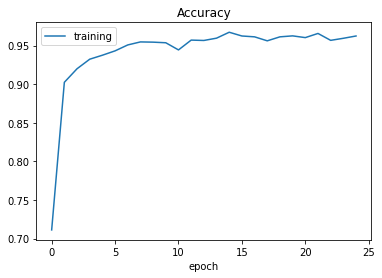

In [ ]:
plt.plot(history_Xception.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend(['training'])

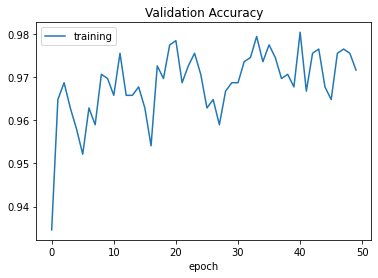

In [ ]:
plt.plot(history_Xception.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(['training'])

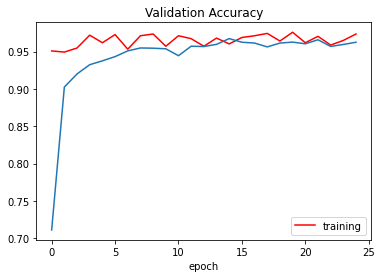

In [ ]:
plt.plot(history_Xception.history['val_accuracy'], color = 'r')
plt.plot(history_Xception.history['accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('epoch')
plt.legend(['training'])

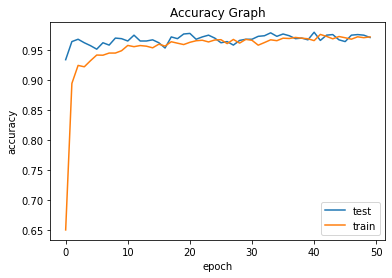

In [ ]:
plt.plot(history_Xception.history['val_accuracy'])
plt.plot(history_Xception.history['accuracy'])
plt.title('Accuracy Graph')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['test', 'train'], loc='lower right')
plt.show()

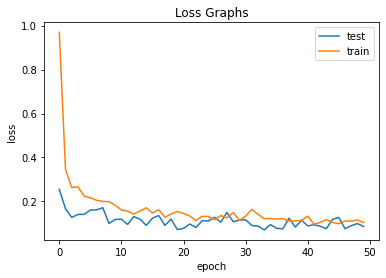

In [ ]:
plt.plot(history_Xception.history['val_loss'])
plt.plot(history_Xception.history['loss'])
plt.title('Loss Graphs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['test', 'train'], loc='upper right')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_Xception.save('/content/gdrive/My Drive/Model/xception.h5')